In [1]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pandas as pd
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Entropy

In [2]:
entropy = pd.read_csv('data/entropy.csv')

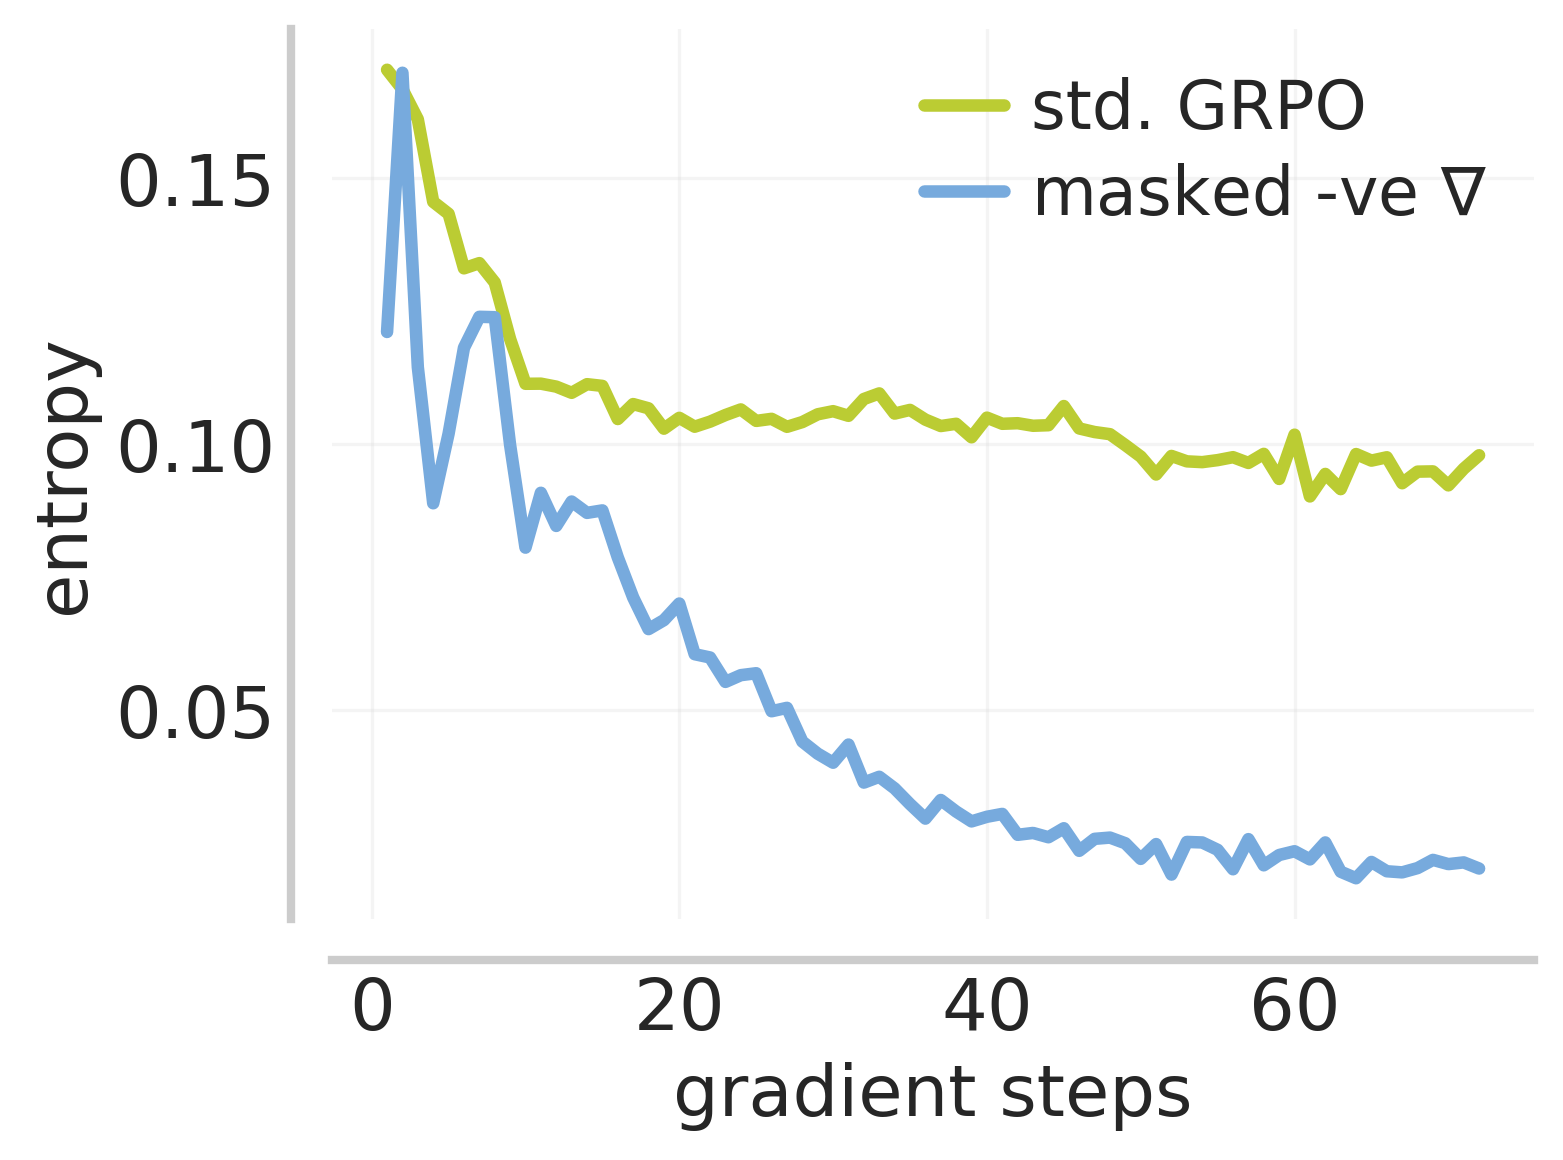

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
fig.set_size_inches(496.0/192*2, 369.6/192*2)

sns.lineplot(data=entropy, x='Step', y='normal - actor/entropy', ax=ax, linewidth=3, markersize=8, color=COLORS[0], label=r'std. GRPO')
sns.lineplot(data=entropy, x='Step', y='positive - actor/entropy', ax=ax, linewidth=3, markersize=8, color=COLORS[1], label=r'masked -ve $\nabla$')

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='gradient steps',
                                        ylabel='entropy',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax.legend(
        prop={'size': 16},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper right",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

plt.savefig("plots/ng_countdown_entropy.pdf", bbox_inches='tight',pad_inches=0)
plt.show()


### Distinct attempts

In [6]:
START_STEP = 0
END_STEP = 72
TEST_FREQ = 12

In [7]:
folder_to_step_to_rollouts = defaultdict(lambda: dict())

for folder in ['normal', 'positive']:
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/{step}_rollouts.json"
        with open(rollouts_file, 'r') as f:
            folder_to_step_to_rollouts[folder][step] = json.load(f)


In [8]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [9]:
def extract_equations(attempt):
    equation_line_pattern = re.compile(r'^([\d\s\+\-\*/=]+)')

    equations = []
    for line in attempt.strip().split('\n'):
        line = line.strip()
        match = equation_line_pattern.match(line)
        if match:
            cleaned_eq = match.group(1).strip()
            equations.append(cleaned_eq)
        elif any(op in line for op in '+-*/='):  # fallback: manually extract left side before any annotation
            cleaned_eq = re.split(r'\s*\(.*?\)', line)[0].strip()
            equations.append(cleaned_eq)

    return equations

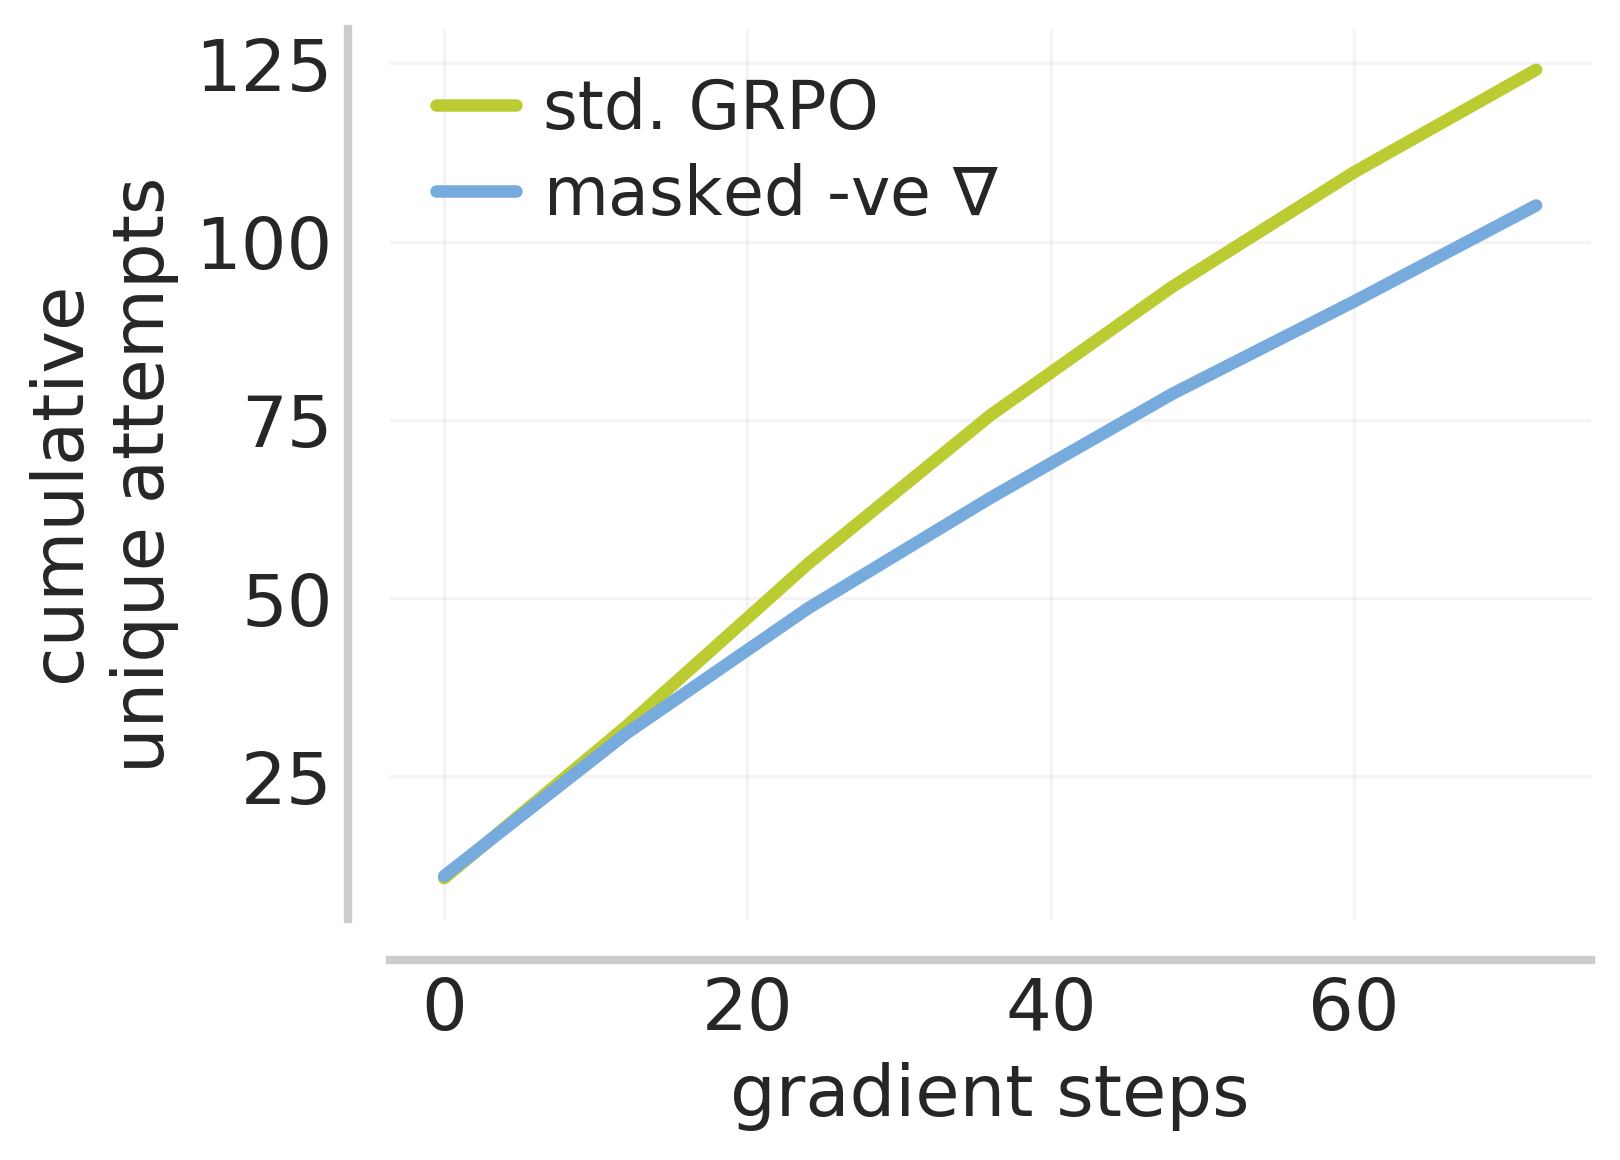

In [13]:
k_fig, k_ax = plt.subplots(nrows=1, ncols=1, dpi=300)
k_fig.set_size_inches(496.0/192*2, 369.6/192*2)

# p_fig, p_ax = plt.subplots(nrows=1, ncols=1)
# p_fig.set_size_inches(496.0/192*2, 369.6/192*2, dpi=300)


for folder in ['normal', 'positive']:
    k = []
    # p = []
    problem_to_cum_attempts = defaultdict(set)
    
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts = folder_to_step_to_rollouts[folder][step]
        problem_to_cur_attempts = defaultdict(set)
        
        attempts = 0
        cur_attempts = 0
        successes = 0
        total = 0
        for i in range(len(rollouts) // 8):
            if rollouts[i * 8]['ref_score'] != 5:
                continue

            for j in range(8):
                rollout = rollouts[i * 8 + j]

                for attempt in set(rollout['output'].split('\n\n')):
                    problem_to_cum_attempts[i].add('\n'.join(extract_equations(attempt)))
                    problem_to_cur_attempts[i].add('\n'.join(extract_equations(attempt)))

                successes += rollout['score']
                total += 1
            
            attempts += len(problem_to_cum_attempts[i])
            cur_attempts += len(problem_to_cur_attempts[i])

        k.append(attempts / total)
        # p.append(successes / cur_attempts)

    if folder == 'normal':
        text = r'std. GRPO'
    else:
        text = r'masked -ve $\nabla$'

    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=k, ax=k_ax, linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}', linestyle='-')
    # sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=p, ax=p_ax, linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}',  linestyle='--')


plt.rcParams["legend.loc"] = "center right"

plot_utils._annotate_and_decorate_axis(k_ax,
                                        xlabel='gradient steps',
                                        ylabel='cumulative \nunique attempts',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

# plot_utils._annotate_and_decorate_axis(p_ax,
#                                         xlabel='gradient steps',
#                                         ylabel='p',
#                                         labelsize='xx-large',
#                                         ticklabelsize='xx-large',
#                                         grid_alpha=0.2,
#                                         legend=True)

k_ax.legend(
        prop={'size': 16},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

# p_ax.legend(
#         prop={'size': 16},         # Slightly smaller font
#         ncol=1,                    # Keep 1 column
#         frameon=False,             # No box
#         handlelength=1.2,          # Shrink line length
#         handletextpad=0.4,         # Shrink space between marker and text
#         borderpad=0.2,             # Shrink border padding inside legend box
#         labelspacing=0.3,          # Reduce vertical space between entries
#         loc="center right",                # Optional: auto position
#         markerscale=0.8,            # Shrink marker size
#         # bbox_to_anchor=(-0.1, 1)
#     )

plt.savefig("plots/ng_countdown_unique_attempts.pdf", bbox_inches='tight',pad_inches=0)

plt.show()